# Clustering the 'Canon' data set

The 'Canon' data set is actually all the images of size 3072x2304 in the Dresden image database.
The number of images in this dataset is 2123.

We have already extracted the noise patterns and computed the similarity scores between all the images. So now we are looking for a way to cluster the images and evaluate different clustering methods. The goal of this notebook is to build up a table of all the images in the dataset and have several columns containing the labels of clusterings produced by different algorithms.

In [1]:
%matplotlib inline

import numpy
import matplotlib.pyplot as pyplot

Now let's start by loading the data set, which is consists of two files. A simple text file with all the filenames, that also encode the ground truth. And secondly and a file that contains the already computed similarity scores between all the files.

In [3]:
filelist = [str(s) for s in numpy.loadtxt("../data/canon/filelist.txt", dtype=numpy.string_)]
matrix_file = "../data/canon/matrix-fuji-pce.dat"
nfiles = len(filelist)
largevis_file = "../data/embedded/coordinates_files/coordinates2D_canon_pce.txt"
output_json_file = "fuji-pce.json"
matrix_pce = numpy.fromfile("../data/canon/matrix-canon-pce.dat", dtype='>d').reshape(nfiles,nfiles)

Next we take a quick look at the similarity scores to get an idea of what they look like and compare them with the ground truth that we know.

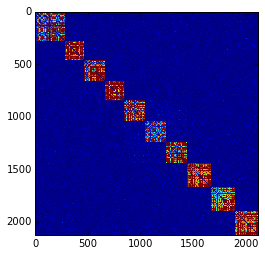

In [4]:
pyplot.imshow(matrix_pce, vmin=0, vmax=80)

Note that the four clusters in the data set are obvious from this plot, but that is only because the rows and columns are sorted according to the ground truth that we know. Before we can continue with clustering we have to convert the similarity scores to distances.

Now we are going to obtain the ground truth, which is encoded in the filenames. 

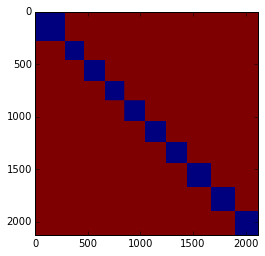

In [5]:
camlist = ["_".join(f.split("_")[:-1]) for f in filelist]

import itertools
ground_truth = list(itertools.product(camlist,camlist))
ground_truth = numpy.array([0 if l[0]==l[1] else 1000 for l in ground_truth]).reshape(2123,2123)

pyplot.imshow(ground_truth, vmin=0, vmax=80)

Next we want to obtain a list of cluster labels for our ground truth.

In [6]:
ground_truth_labels = numpy.array([int(i.split("_")[-1][0]) for i in camlist])
print(ground_truth_labels)

[0 0 0 ..., 2 2 2]


Now that we know the result should look like let's take a look at what a couple of different clustering algorithms make of it.

In [7]:
from clustit.algorithms import hierarchical_clustering
labels_complete = hierarchical_clustering(similarities=matrix_pce, method='complete', threshold=None)
print(labels_complete)

[ 1  1  1 ..., 12 12 12]


In [8]:
labels_average = hierarchical_clustering(similarities=matrix_pce, method='average', threshold=None)
print(labels_average)

[21 21 21 ..., 57 57 57]


In [9]:
labels_centroid = hierarchical_clustering(similarities=matrix_pce, method='centroid', threshold=None)
print(labels_centroid)

[ 46  93   1 ..., 528 593 618]


Let's gather the results we have so far and see if we can quantify which algorithm produced the best clustering

In [10]:
from clustit.algorithms import dbscan
labels_dbscan = dbscan(similarities=matrix_pce, threshold=None)
print(labels_dbscan)

[0 0 0 ..., 4 4 4]


In [11]:
from clustit.algorithms import hierarchical_dbscan
labels_hdbscan = hierarchical_dbscan(similarities=matrix_pce)
print(labels_hdbscan)

[6 6 6 ..., 0 0 0]


In [16]:
from clustit.algorithms import spectral
labels_spectral = spectral(similarities=matrix_pce,n_clusters=4)
print(labels_spectral)

[0 0 0 ..., 1 1 1]


In [18]:
from clustit.algorithms import affinity
labels_affinity = affinity(similarities=matrix_pce)
print(labels_affinity)

[ 7  7  6 ..., 34 34 34]


In [12]:
#read output from LargeVis for this data set
from clustit.output import OutputCollection
oc = OutputCollection(largevis_file=largevis_file)

In [13]:
print(largevis_file)

../data/embedded/coordinates_files/coordinates2D_canon_pce.txt


In [14]:
from clustit.algorithms import kmeans
labels_embedded_kmeans = kmeans(embedded_space=oc, n_clusters=10)
print(labels_embedded_kmeans)

[3 3 3 ..., 6 6 6]


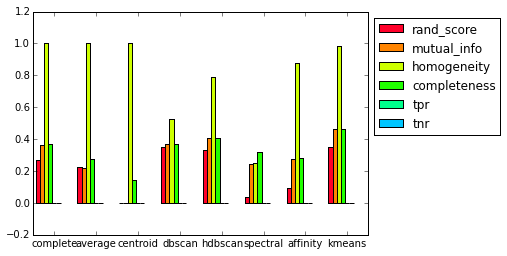

In [19]:
from clustit import metrics
algorithms = ['complete', 'average', 'centroid', 'dbscan', 'hdbscan', 'spectral', 'affinity','kmeans']
labels = [labels_complete, labels_average, labels_centroid, labels_dbscan, labels_hdbscan, labels_spectral, labels_affinity,labels_embedded_kmeans]
metric = ['rand_score', 'mutual_info', 'homogeneity', 'completeness','tpr','tnr']
results = {i:[] for i in metric}

for k,v in zip(algorithms, labels):
    results['rand_score'].append(metrics.adjusted_rand_score(ground_truth_labels, v))
    results['mutual_info'].append(metrics.adjusted_mutual_info_score(ground_truth_labels, v))
    results['homogeneity'].append(metrics.homogeneity_score(ground_truth_labels, v))
    results['completeness'].append(metrics.completeness_score(ground_truth_labels, v))
    results['tpr'].append(metrics.tpr(ground_truth_labels, v))
    results['tnr'].append(metrics.tnr(ground_truth_labels, v))
    
def plot_results(algorithms, metric, results):
    """
    Function that creates a bar char for a list of algorithms
    that have been benchmarked using a list of metrics. 
    Results is a dictionary with metrics as keys, values are lists
    that contain one value per algorithm.
    """
    width = 1.0/(len(algorithms)+2)                             #width that leaves bar of whitespace between groups
    x_ind = numpy.arange(len(algorithms)) + 0.5*width           #0.5 width is to make bargroup centered on its tick
    bars = []
    for i in range(len(metric)):
        color = 1.0/len(x_ind)*i                                #map i into [0,1] to get distinct colors
        bars.append(pyplot.bar(x_ind+i*width, results[metric[i]], width=width, color=pyplot.cm.gist_rainbow(color)))
    ax = pyplot.gcf().gca()
    ax.set_xticks(x_ind + (len(x_ind)/float(2)+0.5)*width)      #nicely center the xticks among the bars
    ax.set_xticklabels(algorithms)
    ax.legend(bars, metric, loc='upper left', bbox_to_anchor=(1, 1))
    
plot_results(algorithms, metric, results)

In [22]:
#read output from LargeVis for this data set
from clustit.output import OutputCollection
oc = OutputCollection(largevis_file='../data/embedded/coordinates_files/coordinates2D_canon_pce.txt')

#add the ground truth as a property to the output for comparison
oc.add_property("ground truth", ground_truth_labels)

#add the labelings from the clustering algorithms as properties to the output collection
for n,l in zip(algorithms, labels):
    oc.add_property(n, l)

#generate a JSON file that can directly be imported by DiVE
json_str = oc.to_DiVE(filename="canon-pce.json")